# 次牛顿方法:BFGS
BFGS是由DFP改良而来的，具有超线性收敛性

In [43]:
import numpy as np
import time

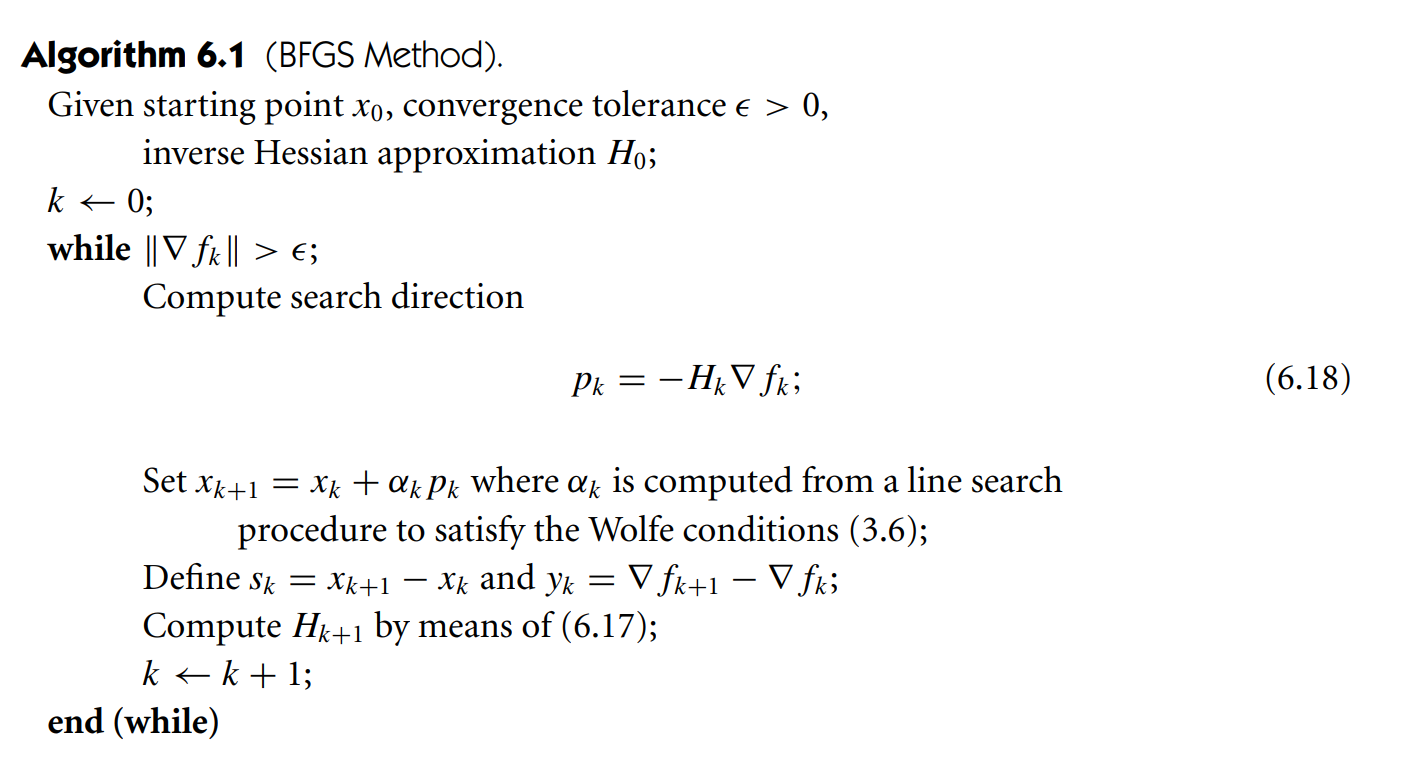

In [44]:
def Zoom(alpha_lo,alpha_hi,d):
    """用于求解合适的步长alpha"""
    #插值（使用二次、三次或二分）来找到alpha_lo和alpha_hi之间的试验步长alpha_j；这里使用二分
    """复用全局x,d,c1,c2,iteration_Max"""
    i=1
    while i<=iteration_Max:
        alpha=(alpha_lo+alpha_hi)/2
        [Phi_alpha,_,phi_alpha_p],[Phi_0,_,phi_0_p]=Function(x+alpha*d,d=d),Function(x+0*d,d=d)
        [Phi_alpha_lo,_,_]=Function(x+alpha_lo*d,d=d)
        if Phi_alpha>Phi_0+c1*alpha*phi_0_p or Phi_alpha>=Phi_alpha_lo:
            alpha_hi=alpha
        else:
            if abs(phi_alpha_p)<=-c2*phi_0_p:return alpha
            if phi_alpha_p*(alpha_hi-alpha_lo)>=0:alpha_hi=alpha_lo
            alpha_lo=alpha
        i+=1
        
    return alpha

In [45]:
def LineSearch(x,d):
    """LineSearch用于找到介于(alpha_min,alpha_max)之间满足上图的alpha"""
    """复用全局x,d,c1,c2,iteration_Max,alpha_max"""
    #x,d为用于传入Function做参数的值
    
    alpha_old=0
    alpha=(alpha_old+alpha_max)/2
    i=1
    while i<=iteration_Max:
        [Phi_alpha,_,phi_alpha_p],[Phi_0,_,phi_0_p]=Function(x+alpha*d,d=d),Function(x+0*d,d=d)
        
        if i<=1:
            if Phi_alpha>Phi_0+c1*alpha*phi_0_p:return Zoom(alpha_old,alpha,d)
        else:
            if Phi_alpha>Phi_0+c1*alpha*phi_0_p or Phi_alpha>=Phi_alpha_old:return Zoom(alpha_old,alpha,d)
            

        if abs(phi_alpha_p)<=-c2*phi_0_p:
            return alpha
        if phi_alpha_p>=0:
            return Zoom(alpha,alpha_old,d)
        
        Phi_alpha_old=Phi_alpha
        alpha_old=alpha
        alpha=(alpha+alpha_max)/2
        i+=1
    return False
    
    


In [46]:
def BFGS(x,printyes):
    """
    n:变量x维数,全局常量
    Function():全局函数
    iteration_Max:最大允许迭代数,全局常数
    expect_error:目标稳定点梯度范数，全局常数
    printyes:打印接口True or False
    """
    #初始化
    if printyes:
        print(f'\n Quasi_Newton BFGS method for solving unconstrained minimization')
        print(f'\n  iter    lstep     norm_GradF   F_new   time    norm_epi')
    start_time = time.time()  # 开始计时

    H=np.eye(n)#这里书上说可以用单位阵也可以用初始点位置的海森近似阵
    _,GradF,_=Function(x)
    norm_GradF=np.linalg.norm(GradF)

    i=1
    while i<=iteration_Max and ((norm_GradF>=expect_error) if expect_error!=None else True):
        _,GradF,_=Function(x)
        #np.array([1,2])用reshape转换成np.array([[1],[2]]),np的矩阵计算可没matlab这么方便
        GradF=GradF.reshape(-1,1)
        d=-H@GradF
        alpha_best=LineSearch(x,d)
        x=x+alpha_best*d
        F_new,GradF_new,_=Function(x)
        norm_GradF=np.linalg.norm(GradF_new)
        
        ###
        s_new=alpha_best*d
        y_new=GradF_new-GradF
        rho=1/(s_new.T@y_new)

        print()
        temp0=s_new@y_new.T####################这里有问题应该算出来的是矩阵但是这里是个数
        temp1=(np.eye(n)-rho*s_new@y_new.T)
        temp2=(np.eye(n)-rho*s_new@y_new.T)@H@(np.eye(n)-rho*y_new@s_new.T)
        temp3=rho*s_new@s_new.T
        H=(np.eye(n)-rho*s_new@y_new.T)@H@(np.eye(n)-rho*y_new@s_new.T)+rho*s_new@s_new.T
    
        elapsed_time = time.time() - start_time  # 计算已经消耗的时间
        
        ###
        norm_epi=np.linalg.norm(x-np.array([1,1]))

        if (printyes):
            print(f"\n {i:3d}    {alpha_best:3.2e}   {norm_GradF:3.2e}   {F_new[0]:3.2e}  {elapsed_time:3.2f}  {norm_epi:3.2e}")
        """
        norm_epi用于检验与手算解的差距
        """
        i+=1

    return x,F_new
     

In [47]:

A,B=np.array([[1],[2]]),np.array([[2],[1]])
A.shape,B.shape
A@B.T

array([[2, 1],
       [4, 2]])

In [48]:
def Function(x,**kwargs):
    "(x,alpha,d)"
    """Function用于计算在该函数某点的值与梯度向量(关于步长alpha的偏导)(与Hessian矩阵)"""
    #这里用一个二次向量式作为例子
    #x:n维向量；A：某不知名正定矩阵
    #A@B等价于np.dot(A,B)
    #A.T=np.transpose(A)

    x1,x2=x[0],x[1]
    F_Value=100*(x2-x1**2)**2+(1-x1)**2
    df_x1,df_x2=x1*(400*x1**2-400*x2+2)-2,200*(x2-x1**2)
    
    F_Gradient=np.array([df_x1,df_x2])

    F_Partial_alpha = None
    if 'd' in kwargs:
        d = kwargs['d']
        F_Partial_alpha=d.T@F_Gradient#Partial_alpha_F(x+alpha*d)
    
    return F_Value,F_Gradient,F_Partial_alpha
    

# MainProgram

In [49]:
np.random.seed(20241002)
c1,c2,alpha_max=1e-4,0.9,2
n=2
iteration_Max=50
expect_error=1e-13
x = np.array([[-2],[0]])
x_sol,F_sol=BFGS(x,True)


 Quasi_Newton BFGS method for solving unconstrained minimization

  iter    lstep     norm_GradF   F_new   time    norm_epi


   1    9.77e-04   2.46e+02   2.48e+01  0.00  3.60e-01


   2    1.56e-02   8.47e+02   6.26e+02  0.50  2.82e+00


   3    1.00e+00   5.01e+01   1.24e+00  1.01  1.74e-01


   4    1.00e+00   1.05e+01   5.29e-02  1.51  7.28e-02


   5    1.00e+00   1.05e-01   7.31e-04  2.02  8.62e-02


   6    1.00e+00   3.38e-02   7.22e-04  2.52  8.59e-02


   7    1.50e+00   4.74e-02   7.20e-04  3.03  8.58e-02


   8    1.00e+00   1.67e-01   6.94e-04  3.54  8.34e-02


   9    1.00e+00   2.99e-01   6.48e-04  4.04  7.86e-02


  10    1.00e+00   4.83e-01   5.36e-04  4.54  6.57e-02


  11    1.00e+00   5.95e-01   3.68e-04  5.05  4.45e-02


  12    1.00e+00   5.06e-01   1.67e-04  5.56  2.01e-02


  13    1.00e+00   1.90e-01   1.94e-05  6.06  3.90e-03


  14    1.00e+00   1.17e-02   1.00e-07  6.57  5.62e-04


  15    1.00e+00   7.36e-05   6.78e-10  7.07  8.23e-05


  16    1.00e+00  

KeyboardInterrupt: 